# Metric Learning + *KNN*

A primeira atividade dessa lista consiste em implementar o algoritmo K-Nearest Neighbours (*KNN*). Se trata de um algoritmo de aprendizado supervisionado comumente utilizado para classificar amostras com base nos rótulos dos K vizinhos mais próximos. Deverá ser implentado um classificador *KNN* que utilize uma métrica de Mahalanobis, cujos parâmetros são obtidos através de um processo de otimização.

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.neighbors import DistanceMetric
from scipy.spatial.distance import cdist
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## Dados

Os dados foram gerados em R utilizando o código especificado no enunciado desse exercício.

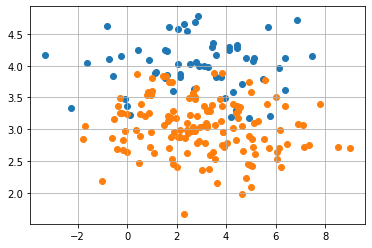

In [2]:
data = pd.read_csv('data.csv', names=['X1', 'X2', 'Y'], header=None)
data = data.drop(0, axis=0)
X = data[['X1', 'X2']].to_numpy()
y = data['Y'].to_numpy()
y[y=='1'] = 1
y[y=='2'] = 0
y = np.array(y.tolist())
for class_value in [0, 1]:
    # get row indexes for samples with this class
    row_ix = np.where(y == class_value)
    # create scatter of these samples
    plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')
plt.grid()

## Aprendizado de Métrica

Será utilizada uma métrica de Mahalanobis, cujos parâmetros (matriz V) serão obtidos através de um processo de otimização. Como função objetivo para a otimização, busca-se maximizar a Silhueta média do conjunto de dados. O método de otimização utilizado foi um
algoritmo genético. Como a função da biblioteca utilizada trabalha apenas com minimização, então a função objetivo retorna $(- silhueta_{média})$.

In [3]:
def objective_function(v):
    v.reshape(2,2)
    # The silhouette_score gives the average value for all the samples.
    kwargs = {'metric': 'mahalanobis', 'VI': v}
    silhouette_avg = silhouette_score(X, y, **kwargs)
    return -silhouette_avg  

 The best solution found:                                                                           
 [ 6.78741497e-03  8.89750039e+00 -8.40552061e+00  8.91535304e+00]

 Objective function:
 -0.4420188273746906


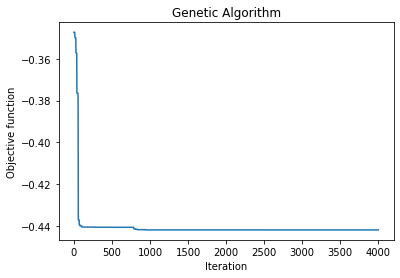

In [4]:
from geneticalgorithm import geneticalgorithm as ga
varbound=np.array([[-10,10]]*4)
model=ga(function=objective_function, dimension=4, variable_type='real',variable_boundaries=varbound)
model.run()
v = model.output_dict['variable'].reshape(2,2)
print(v) 

## Comparação entre a métrica aprendida e a métrica euclidiana

### Matriz de Distâncias

In [5]:
dist_mahalanobis = cdist(X, X, 'mahalanobis', v)
dist_euclidian = cdist(X, X, 'euclidean', v)

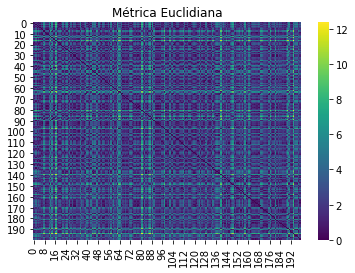

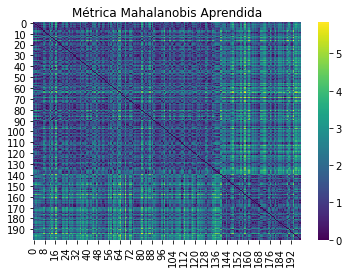

In [6]:
import seaborn as sns
sns.heatmap(dist_euclidean, cmap='viridis')
plt.title('Métrica Euclidiana')
plt.show()
sns.heatmap(dist_mahalanobis, cmap='viridis')
plt.title('Métrica Mahalanobis Aprendida')
plt.show()

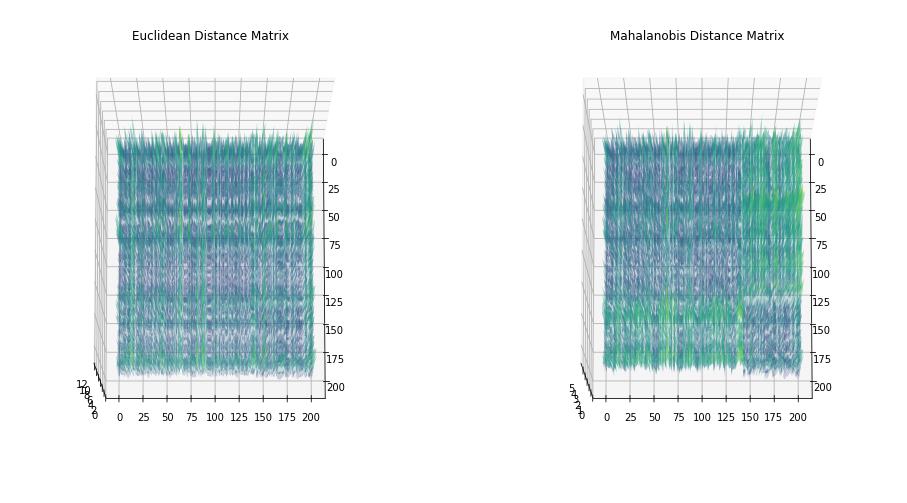

In [7]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(121, projection='3d')
X1, X2 = np.meshgrid(np.linspace(1,200,200), np.linspace(1,200,200))
ax.plot_surface(X1, X2, dist_euclidean, rstride=1, cstride=1, alpha=0.25, cmap='viridis', edgecolor='none')
ax.set_title('Euclidean Distance Matrix')
ax.view_init(80, 0)
ax = fig.add_subplot(122, projection='3d')
X1, X2 = np.meshgrid(np.linspace(1,200,200), np.linspace(1,200,200))
ax.plot_surface(X1, X2, dist_mahalanobis, rstride=1, cstride=1, alpha=0.25, cmap='viridis', edgecolor='none')
ax.set_title('Mahalanobis Distance Matrix')
ax.view_init(80, 0)

### Silhueta 

Using euclidean metric, the average silhouette_score is: 0.08865515674470942
Using mahalanobis metric, the average silhouette_score is: 0.4420188273746906


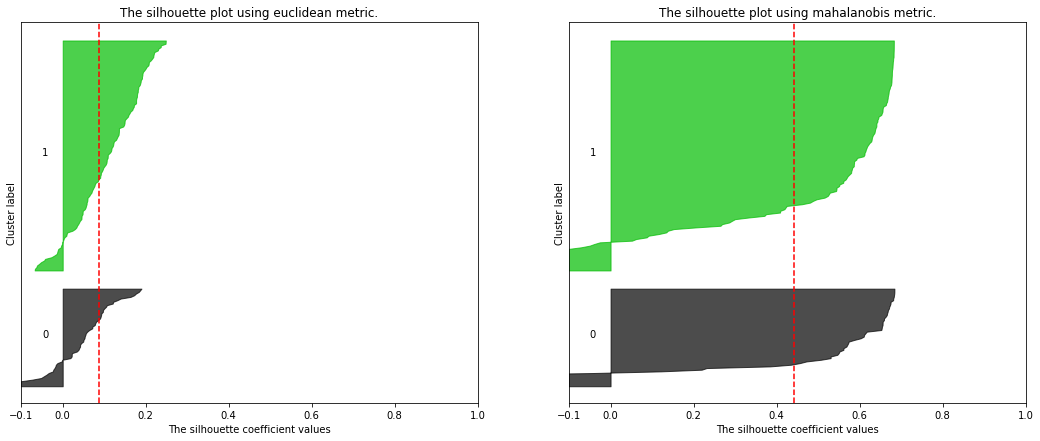

In [10]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
range_n_clusters = [2]

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
ax = (ax1, ax2)
fig.set_size_inches(18, 7)
n_clusters = 2
i = 0
for metric in ["euclidean", "mahalanobis"]:
    ax[i].set_xlim([-0.1, 1])
    ax[i].set_ylim([0, len(X) + (n_clusters + 1) * 10])

    if metric == "euclidean":
        kwargs = {'metric': metric}
    elif metric == "mahalanobis":
        kwargs = {'metric': metric, 'VI': v}
    silhouette_avg = silhouette_score(X, y, **kwargs)
    print(f"Using {metric} metric, the average silhouette_score is: {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, y,  **kwargs)

    y_lower = 10
    for j in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[y == j]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(j) / n_clusters)
        ax[i].fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax[i].text(-0.05, y_lower + 0.5 * size_cluster_i, str(j))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax[i].set_title(f'The silhouette plot using {metric} metric.')
    ax[i].set_xlabel("The silhouette coefficient values")
    ax[i].set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax[i].axvline(x=silhouette_avg, color="red", linestyle="--")
    ax[i].set_yticks([])  # Clear the yaxis labels / ticks
    ax[i].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    i += 1

Nos gráficos de Silhuetas mostrados acima é possível observar um melhor resultado da métrica aprendida. Ao utilizá-la foi possível encontrar uma silhueta média de aproximadamente 0.44, valor consideravelmente maior se comparado a silhueta média calculada utilizando a métrica euclidiana (aproximadamente 0.089).

##  Modelo KNN:

Abaixo é possível observar uma possível implementação do algoritmo *Knn*.

In [11]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

def manhattan_distance(x1, x2):
    return np.sum(abs(x1 - x2))
    
class Knn(BaseEstimator, ClassifierMixin):

    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X_train = X # X can have any features - matrix
        self.y_train = y # y is a vector

    def predict(self, X, distance_type, v=None):
        y_hat = [self._predict(x, distance_type, X, v) for x in X]
        return np.array(y_hat)

    def _predict(self, x, distance_type, X, v=None):
        # Calculate distances between x and all samples in X_train
        if distance_type == 'euclidean':
            distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        elif distance_type == 'manhattan':
            distances = [manhattan_distance(x, x_train) for x_train in self.X_train]
        elif distance_type == 'mahalanobis':
            distances = (cdist(x.reshape(1,2), self.X_train, 'mahalanobis', v)).tolist()
            # Just flat list:
            distances = [item for sublist in distances for item in sublist]
        else:
            print("ERROR: invalid distance type.")
        # Sort by distance and return indices of the first k neighbors
        k_idx = np.argsort(distances)[:self.k]
        # Get the labels of the k nearest neighbors
        k_neighbor_labels = [self.y_train[i] for i in k_idx] 
        # Pick the most commom label
        most_common = Counter(k_neighbor_labels).most_common(1)
        return int(most_common[0][0])

## Aplicação do Modelo

Para avaliar a eficácia de se utilizar *Metric Learning*, foram gerados modelos Knn utilizando a métrica Mahalanobis aprendida anteriormente e a métrica euclidiana. Para avaliação dos modelos foi realizado um *10-fold cross-validation*, e as acurácias médias foram calculadas e mostradas abaixo. Além disso, foram gerados *KNNs* com diferentes valores de K.

In [16]:
def results(X, y, n_splits, v):  
    for k in [3, 5, 7, 9, 11, 13, 15]:
        clf = Knn(k)
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True)
        i=0

        train_accuracy_m = np.zeros(n_splits)
        test_accuracy_m = np.zeros(n_splits)

        train_accuracy_e = np.zeros(n_splits)
        test_accuracy_e = np.zeros(n_splits)

        for train_index, test_index in kf.split(X, y.tolist()):
            X_train = X[train_index,:]
            X_test = X[test_index,:]
            y_train = y[train_index]
            y_test = y[test_index]

            # KNN Euclidean
            clf = Knn(3)
            clf.fit(X_train, y_train)
            y_hat_train = clf.predict(X_train, "euclidean")
            y_hat = clf.predict(X_test, "euclidean")
            test_accuracy_e[i] = accuracy_score(y_test, y_hat)
            train_accuracy_e[i] = accuracy_score(y_train, y_hat_train)   
            
            # KNN Mahalanobis
            y_hat_train = clf.predict(X_train, "mahalanobis", v)
            y_hat = clf.predict(X_test, "mahalanobis", v)
            train_accuracy_m[i] = accuracy_score(y_train, y_hat_train)   
            test_accuracy_m[i] = accuracy_score(y_test, y_hat)
            i+=1
        
        print(f"********* Results KNN K = {k}**************")
        print("KNN using euclidean metric:")
        print("Acc train: " + '{:.4f}'.format(train_accuracy_e.mean())+ "+/-" + '{:.4f}'.format(train_accuracy_e.std()))
        print("Acc test: " + '{:.4f}'.format(test_accuracy_e.mean()) + "+/-" + '{:.4f}'.format(test_accuracy_e.std()))
        print("KNN using learned mahalanobis metric:")
        print("Acc train: " + '{:.4f}'.format(train_accuracy_m.mean())+ "+/-" + '{:.4f}'.format(train_accuracy_m.std()))
        print("Acc test: " + '{:.4f}'.format(test_accuracy_m.mean()) + "+/-" + '{:.4f}'.format(test_accuracy_m.std()))

In [17]:
results(X, y, 10, v)

********* Results KNN K = 3**************
KNN using euclidean metric:
Acc train: 0.9156+/-0.0119
Acc test: 0.8350+/-0.0502
KNN using learned mahalanobis metric:
Acc train: 0.9206+/-0.0056
Acc test: 0.8500+/-0.0548
********* Results KNN K = 5**************
KNN using euclidean metric:
Acc train: 0.9156+/-0.0082
Acc test: 0.8650+/-0.0743
KNN using learned mahalanobis metric:
Acc train: 0.9194+/-0.0076
Acc test: 0.8700+/-0.0714
********* Results KNN K = 7**************
KNN using euclidean metric:
Acc train: 0.9172+/-0.0101
Acc test: 0.8400+/-0.0800
KNN using learned mahalanobis metric:
Acc train: 0.9206+/-0.0070
Acc test: 0.8600+/-0.0768
********* Results KNN K = 9**************
KNN using euclidean metric:
Acc train: 0.9189+/-0.0109
Acc test: 0.8450+/-0.0568
KNN using learned mahalanobis metric:
Acc train: 0.9222+/-0.0075
Acc test: 0.8650+/-0.0634
********* Results KNN K = 11**************
KNN using euclidean metric:
Acc train: 0.9161+/-0.0101
Acc test: 0.8250+/-0.0335
KNN using learned ma

Pode-se notar acima que em todos os casos o modelo *KNN* utilizando a métrica aprendida obteve resultados melhores ou iguais ao *KNN* utilizando a métrica euclidiana.

# Conclusão

Com essa lista foi possível implementar, entender e aplicar os conceitos relativos ao algoritmo *Knn*. Como vimos, o algoritmo de k-vizinhos mais próximos (KNN) é um algoritmo de aprendizado de máquina supervisionado simples e fácil de implementar que pode ser usado para resolver problemas de classificação e regressão. Apesar de nesse relatório ter-se utilizado o Knn para a classificação, o mesmo pode ser usado também em problemas de regressão, nesse caso, a previsão é normalmente baseada na média ou na mediana das amostras mais semelhantes.

Foi possível também observar a eficácia da técnica de aprendizado de métrica. Nesse exercício foi utilizada uma métrica de Mahalanobis, cujos parâmetros foram obtidos através de um processo de otimização (GA). Ao se comparar um classificador KNN utilizando a métrica aprendida com a um similar utilizando uma métrica euclidiana, foi possível observar que em todos os casos testados o modelo com a métrica aprendida obteve resultados superiores.